In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

--------
## Optimization

__Load previous results:__

In [2]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
t = Table.read('/Users/roz18/git/desi-photoz/test/clustering_demo_results.txt', format='ascii.commented_header')

hp_ra = np.array(t['ra'])
hp_dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels_original = np.array(t['label'])

labels = np.copy(labels_original)

__Identify the neighbors of each occupied pixel:__

3010 bordering pixels


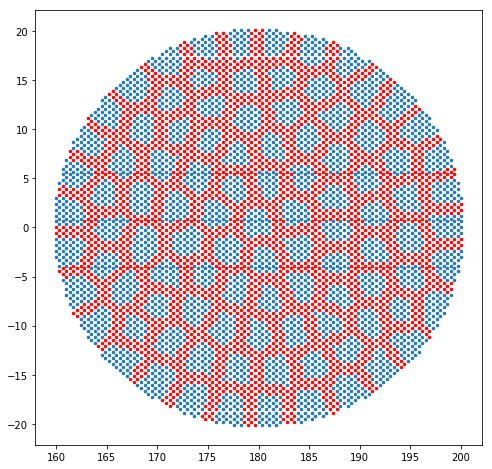

In [3]:
pix_id = hp.pixelfunc.ang2pix(NSIDE, hp_ra, hp_dec, lonlat=True)

neighbors = hp.get_all_neighbours(NSIDE, hp_ra, hp_dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert to native numpy indices of the pixels
# pointer from healpy indices to pixel indices:
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(hp_ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# Find bordering pixels
mask1 = labels[neighbors] != labels[:, None]
mask2 = neighbors>=0
mask_border = np.any(mask1 & mask2, axis=1)
print(np.sum(mask_border), 'bordering pixels')
plt.figure(figsize=(8, 8))
plt.plot(hp_ra[~mask_border], hp_dec[~mask_border], '.', markersize=5)
plt.plot(hp_ra[mask_border], hp_dec[mask_border], 'r.', markersize=5)
plt.show()

In [4]:
# Default parameters:
default_params = {
    'pop_size': 50,   # population size
    'surv_rate': 1.,
    'mutate_rate': 0.001,
    'ngen': 2000,  # number of generations to run
    'tournament_k':3, # number of individuals in tournament selection
    'equality_weight': 80., # weight of imposing equal weighted pix counts in fitness function
    'spherical': True, 
}

ngroup = len(np.unique(labels))

In [5]:
import optimized_pixel_partition
# reload(optimized_pixel_partition)

# Initialize
optimizer = optimized_pixel_partition.Subsampler(hp_ra, hp_dec, labels, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [6]:
# np.random.seed(2)

############################## Evolve! ##############################
time_start = time.time()
for idx_gen in range(default_params['ngen']):

    # update the fitness scores
    optimizer.fitness()
    
    # print status
    best = np.argmax(optimizer.scores)
    if idx_gen%10==0:
        print('{:5d} {:11.8g} {:11.8g} {:11.8g}'.\
              format(idx_gen, optimizer.scores[best], optimizer.compactness[best], optimizer.equality[best]))

    # select survivers
    survivers, scores = optimizer.selection()
    
    # rebuild solution array and mutate
    optimizer.labels_all = optimizer.labels_all[survivers]
    optimizer.mutate()
    
print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

    0  -160.86067    145.2583   15.602371
   10  -160.81369   145.27425   15.539438
   20  -160.76081   145.30936   15.451442
   30  -160.72285   145.36434   15.358513
   40   -160.6963    145.4421   15.254204
   50  -160.64959   145.47221   15.177384
   60  -160.59923   145.49262   15.106611
   70  -160.57126   145.53907   15.032186
   80  -160.53888   145.59458   14.944304
   90  -160.50649   145.62646   14.880034
  100  -160.47456   145.67796   14.796593
  110  -160.43347   145.69747   14.735996
  120  -160.39698   145.80349   14.593489
  130  -160.36226   145.73638   14.625881
  140  -160.30813   145.79413      14.514
  150  -160.27043   145.81449   14.455938
  160  -160.22558   145.93519   14.290391
  170  -160.20704   145.91562   14.291421
  180  -160.15195   146.00361   14.148336
  190  -160.11136   145.97693    14.13443
  200  -160.06999   146.01718   14.052804
  210  -160.03104   146.01586   14.015186
  220  -160.00481   146.01869   13.986126
  230  -159.98659   146.10523   13

 1960  -153.26321   146.77477   6.4884446
 1970  -153.22748   146.82063   6.4068561
 1980  -153.20242   146.81697   6.3854481
 1990  -153.16184   146.82265   6.3391898
00:09:58


AttributeError: Subsampler instance has no attribute 'labels'

In [7]:
labels = optimizer.labels_all[best]
w_counts = optimizer.counts[best]

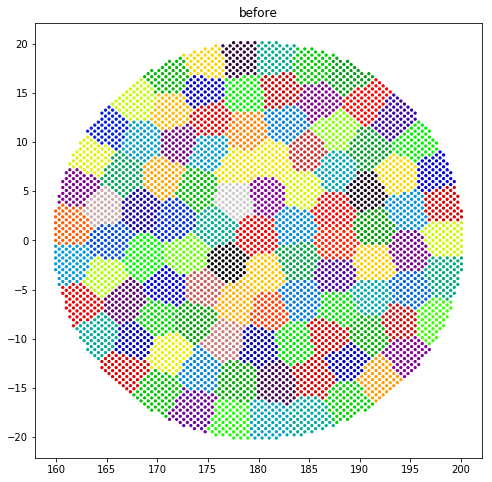

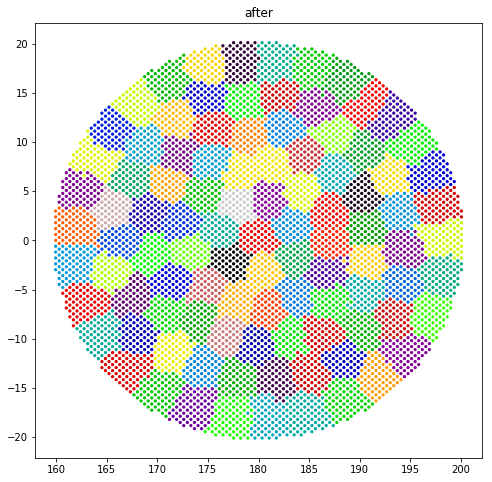

In [8]:
# Original grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels_original, cmap=plt.cm.spectral, s=5)
plt.title('before')
plt.show()

# Final grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.title('after')
plt.show()

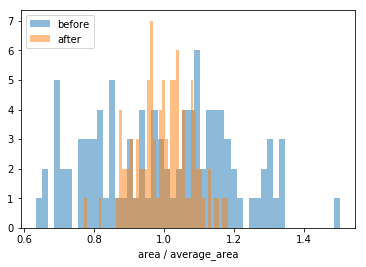

In [9]:
group_counts_original = np.zeros(ngroup)
for idx_grp in range(ngroup):
    members = np.where(labels_original==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])

plt.hist(group_counts_original/optimizer.average_count, 50, alpha=0.5, label='before')
plt.hist(w_counts/optimizer.average_count, 50, alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()